In [7]:
import numpy as np
import itertools as iters
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
import scipy
import networkx as nx

In [58]:
%run metro_generic.py

In [59]:
%run DCA/treewidth.py

In [5]:
#extract a variable ordering and set of active nodes from a junction tree
def get_ordering(T):
    T = T.copy()
    order = []
    active_frontier = []
    
    while(T.number_of_nodes() > 0):
        gen = (x for x in T.nodes() if T.degree(x) <= 1)
        active_node = next(gen)
        parents = list(T[active_node].keys())
        if(len(parents) == 0):
            active_vars = set(active_node)
            activated_set = active_vars.copy()
        else:
            active_vars = set(active_node.difference(parents[0]))
            activated_set = active_vars.union(parents[0]).difference(set(order))
        for i in active_vars:
            order += [i]
            frontier = list(activated_set.difference(set(order)))
            active_frontier += [frontier]
        T.remove_node(active_node)
    
    return [np.array(order), active_frontier]

## 2x2 Ising Model

In [113]:
dims = (2,2)
d = dims[0] * dims[1]
beta_0 = .3

def lf(x, beta = beta_0):
    #Ising model density

    temp = 0
    for j in range(d) :
        if j % dims[0] > 0:
            temp += x[j] * x[j - 1]
        if j % dims[0] < dims[0] - 1:
            temp += x[j] * x[j + 1]
        if j - dims[0] >= 0:
            temp += x[j] * x[j - dims[0]]
        if j + dims[0] < d:
            temp += x[j] * x[j + dims[0]]
     
    return beta * temp  / 2

def ising_sampler(lf, dims, beta = beta_0, n_iter = 500):
    d = dims[0] * dims[1]
    x = np.random.binomial(1, .5, size = d) * 2 - 1
    for _ in range(n_iter):
        j = np.random.choice(d)
        x0 = x.copy()
        x0[j] = -1
        x1 = x.copy()
        x1[j] = 1
        p0 = np.exp(lf(x0, beta))
        p1 = np.exp(lf(x1, beta))
        u = np.random.binomial(1, p0 / (p1 + p0))
        if u == 1:
            x = x0
        else:
            x = x1
    
    return x

In [114]:
G = nx.Graph()
G.add_nodes_from(range(d))

for j in range(d):
    if j % dims[0] > 0:
        G.add_edge(j - 1, j)
    if j % dims[0] < dims[0] - 1:
        G.add_edge(j, j + 1)
    if j - dims[0] >= 0:
        G.add_edge(j, j - dims[0])
    if j + dims[0] < d:
        G.add_edge(j, j + dims[0])

In [115]:
tree_decomp = treewidth_decomp(G)
tree_decomp[0]

2

In [116]:
out = get_ordering(tree_decomp[1])
order = out[0]
active_frontier = out[1]

In [117]:
order

array([3, 0, 1, 2])

In [118]:
active_frontier

[[0, 1, 2], [1, 2], [2], []]

In [119]:
def sym_prop(j, xj):
    return np.random.choice([-1, 1])

In [120]:
x = ising_sampler(lf, dims)
xk = single_metro(lf, x, order, active_frontier, sym_prop)

In [121]:
np.mean(x == xk)

1.0

In [129]:
%%time

np.random.seed(999)
n_rep = 20000
res = np.zeros((n_rep, 2*d))
for i in range(n_rep):
    x = ising_sampler(lf, dims, n_iter = 50)
    xk = single_metro(lf, x, order, active_frontier, sym_prop)
    res[i, :] = np.concatenate((x, xk))
    
emp_cov = np.cov(res, rowvar = False)

CPU times: user 1min 8s, sys: 298 ms, total: 1min 9s
Wall time: 1min 9s


In [130]:
np.mean(res[:, 0:d] == res[:, d:(2*d)])

0.7115625

In [131]:
np.mean(res, axis = 0) * np.sqrt(n_rep)

array([ 1.668772  ,  1.76776695, -0.33941125, -0.77781746,  1.65462987,
        1.24450793, -0.45254834,  0.98994949])

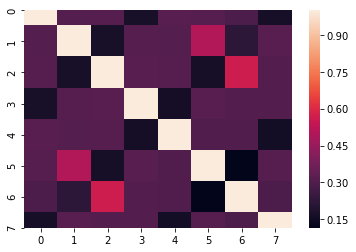

In [132]:
sns.heatmap(emp_cov)

In [128]:
%%time

np.random.seed(100)
n_rep = 20000
res = np.zeros((n_rep, d))
for i in range(n_rep):
    res[i, :] = ising_sampler(lf, dims, n_iter = 50)
    
ho_cov = np.cov(res, rowvar = False)
ho_cov

CPU times: user 49 s, sys: 218 ms, total: 49.2 s
Wall time: 49.5 s


In [133]:
orig_marg = emp_cov[0:d, 0:d]
print(np.max(np.abs(orig_marg - ho_cov)))
ko_marg = emp_cov[d:(2*d), d:(2*d)]
print(np.max(np.abs(ko_marg - ho_cov)))

ko_orig_cross = emp_cov[0:d, d:(2*d)] - ho_cov
np.fill_diagonal(ko_orig_cross, 0)
print(np.max(np.abs(ko_orig_cross)))

0.011952617630881623
0.04890602530126474
0.05661109055452773


In [138]:
print(np.mean(np.abs(orig_marg - ho_cov)))
print(np.mean(np.abs(ko_marg - ho_cov)))
print(np.mean(np.abs(ko_orig_cross)))

0.005583557927896908
0.012879674608730051
0.00858259662983134


## 3x3 Ising Model

In [139]:
dims = (3,3)
d = dims[0] * dims[1]
beta_0 = .3

def lf(x, beta = beta_0):
    #Ising model density

    temp = 0
    for j in range(d) :
        if j % dims[0] > 0:
            temp += x[j] * x[j - 1]
        if j % dims[0] < dims[0] - 1:
            temp += x[j] * x[j + 1]
        if j - dims[0] >= 0:
            temp += x[j] * x[j - dims[0]]
        if j + dims[0] < d:
            temp += x[j] * x[j + dims[0]]
     
    return beta * temp  / 2

def ising_sampler(lf, dims, beta = beta_0, n_iter = 500):
    d = dims[0] * dims[1]
    x = np.random.binomial(1, .5, size = d) * 2 - 1
    for _ in range(n_iter):
        j = np.random.choice(d)
        x0 = x.copy()
        x0[j] = -1
        x1 = x.copy()
        x1[j] = 1
        p0 = np.exp(lf(x0, beta))
        p1 = np.exp(lf(x1, beta))
        u = np.random.binomial(1, p0 / (p1 + p0))
        if u == 1:
            x = x0
        else:
            x = x1
    
    return x

In [140]:
G = nx.Graph()
G.add_nodes_from(range(d))

for j in range(d):
    if j % dims[0] > 0:
        G.add_edge(j - 1, j)
    if j % dims[0] < dims[0] - 1:
        G.add_edge(j, j + 1)
    if j - dims[0] >= 0:
        G.add_edge(j, j - dims[0])
    if j + dims[0] < d:
        G.add_edge(j, j + dims[0])

In [141]:
tree_decomp = treewidth_decomp(G)
tree_decomp[0]

3

In [142]:
out = get_ordering(tree_decomp[1])
order = out[0]
active_frontier = out[1]

In [143]:
order

array([8, 6, 7, 2, 4, 5, 0, 1, 3])

In [144]:
active_frontier

[[3, 4, 5, 7],
 [3, 4, 5, 7],
 [1, 3, 4, 5],
 [1, 3, 4, 5],
 [0, 1, 3, 5],
 [0, 1, 3],
 [1, 3],
 [3],
 []]

In [145]:
def sym_prop(j, xj):
    return np.random.choice([-1, 1])

In [146]:
x = ising_sampler(lf, dims)
xk = single_metro(lf, x, order, active_frontier, sym_prop)

In [147]:
np.mean(x == xk)

0.7777777777777778

In [155]:
%%time

np.random.seed(999)
n_rep = 2000
res = np.zeros((n_rep, 2*d))
for i in range(n_rep):
    x = ising_sampler(lf, dims, n_iter = 200)
    xk = single_metro(lf, x, order, active_frontier, sym_prop)
    res[i, :] = np.concatenate((x, xk))
    
emp_cov = np.cov(res, rowvar = False)

CPU times: user 54.1 s, sys: 655 ms, total: 54.8 s
Wall time: 1min


In [156]:
np.mean(res[:, 0:d] == res[:, d:(2*d)])

0.7411111111111112

In [157]:
np.mean(res, axis = 0) * np.sqrt(n_rep)

array([-0.31304952, -0.62609903,  0.13416408,  1.43108351,  1.6546903 ,
       -1.52052622, -0.13416408, -0.84970583,  1.56524758, -0.62609903,
       -0.4472136 ,  0.2236068 ,  1.43108351, -1.34164079, -1.25219807,
        0.31304952, -1.11803399,  0.40249224])

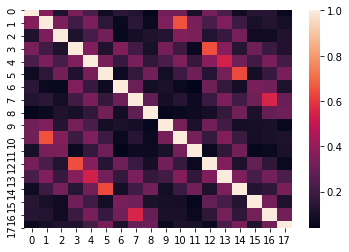

In [158]:
sns.heatmap(emp_cov)

In [159]:
%%time

np.random.seed(100)
n_rep = 2000
res = np.zeros((n_rep, d))
for i in range(n_rep):
    res[i, :] = ising_sampler(lf, dims, n_iter = 200)
    
ho_cov = np.cov(res, rowvar = False)
ho_cov

CPU times: user 30 s, sys: 141 ms, total: 30.1 s
Wall time: 30.3 s


In [160]:
orig_marg = emp_cov[0:d, 0:d]
print(np.max(np.abs(orig_marg - ho_cov)))
ko_marg = emp_cov[d:(2*d), d:(2*d)]
print(np.max(np.abs(ko_marg - ho_cov)))

ko_orig_cross = emp_cov[0:d, d:(2*d)] - ho_cov
np.fill_diagonal(ko_orig_cross, 0)
print(np.max(np.abs(ko_orig_cross)))

0.07009504752376176
0.09792896448224156
0.08406203101550816


In [161]:
print(np.mean(np.abs(orig_marg - ho_cov)))
print(np.mean(np.abs(ko_marg - ho_cov)))
print(np.mean(np.abs(ko_orig_cross)))

0.020180855860028667
0.025347883818452287
0.021013074438453825
